##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer learning with TensorFlow Hub

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

[TensorFlow Hub](https://tfhub.dev/) is a repository of pre-trained TensorFlow models.

This tutorial demonstrates how to:

1. Use models from TensorFlow Hub with `tf.keras`
1. Use an image classification model from TensorFlow Hub
1. Do simple transfer learning to fine-tune a model for your own image classes

## Setup

In [2]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

## An ImageNet classifier

You'll start by using a pretrained classifer model to take an image and predict what it's an image of - no training required!

### Download the classifier

Use `hub.KerasLayer` to load a [MobileNetV2 model](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2) from TensorFlow Hub. Any [compatible image classifier model](https://tfhub.dev/s?q=tf2&module-type=image-classification) from tfhub.dev will work here.

In [3]:
classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4" #@param {type:"string"}

In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

### Run it on a single image

Download a single image to try the model on.

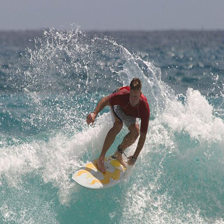

In [5]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension, and pass the image to the model.

In [7]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax:

In [8]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

694

### Decode the predictions

Take the predicted class ID and fetch the `ImageNet` labels to decode the predictions

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

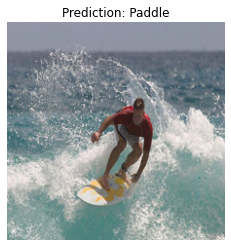

In [10]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Simple transfer learning

But what if you want to train a classifier for a dataset with different classes? You can also use a model from TFHub to train a custom image classier by retraining the top layer of the model to recognize the classes in our dataset.

### Dataset

 For this example you will use the TensorFlow flowers dataset:

In [11]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

     8192/228813984 [..............................] - ETA: 3s

  8396800/228813984 [>.............................] - ETA: 2s

 16785408/228813984 [=>............................] - ETA: 2s

 30031872/228813984 [==>...........................] - ETA: 1s

 44998656/228813984 [====>.........................] - ETA: 1s

 58630144/228813984 [======>.......................] - ETA: 0s

 58728448/228813984 [======>.......................] - ETA: 2s

 71778304/228813984 [========>.....................] - ETA: 2s

 87801856/228813984 [==========>...................] - ETA: 1s

103170048/228813984 [============>.................] - ETA: 1s

118571008/228813984 [==============>...............] - ETA: 1s

131883008/228813984 [================>.............] - ETA: 0s

147390464/228813984 [==================>...........] - ETA: 0s

162824192/228813984 [====================>.........] - ETA: 0s

177635328/228813984 [======================>.......] - ETA: 0s

192946176/228813984 [========================>.....] - ETA: 0s

201334784/228813984 [=========================>....] - ETA: 0s

213590016/228813984 [===========================>..] - ETA: 0s

224534528/228813984 [============================>.] - ETA: 0s

228818944/228813984 [==============================] - 2s 0us/step


Let's load this data into our model using  images off disk using image_dataset_from_directory.

In [12]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


The flowers dataset has five classes.

In [13]:
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


TensorFlow Hub's conventions for image models is to expect float inputs in the `[0, 1]` range. Use the `Rescaling` layer to achieve this.

Note: you could also include the `Rescaling` layer inside the model. See this [guide](https://www.tensorflow.org/guide/keras/preprocessing_layers) for a discussion of the tradeoffs.

In [14]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### Run the classifier on a batch of images

Now run the classifier on the image batch.

In [17]:
result_batch = classifier.predict(train_ds)

In [18]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'coral fungus', 'rapeseed', ..., 'daisy', 'daisy',
       'birdhouse'], dtype='<U30')

Now check how these predictions line up with the images:

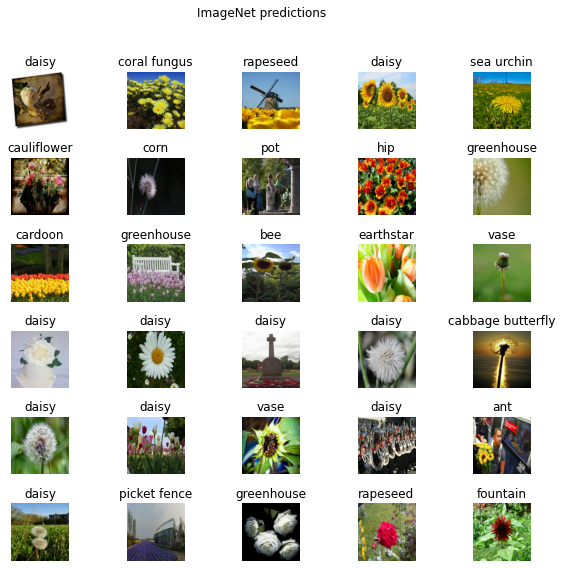

In [19]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

See the `LICENSE.txt` file for image attributions.

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except "daisy").

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [compatible image feature vector model](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from tfhub.dev will work here.

In [20]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #@param {type:"string"}

Create the feature extractor. Use `trainable=False` to freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [21]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

It returns a 1280-length vector for each image:

In [22]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [23]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
predictions = model(image_batch)

In [25]:
predictions.shape

TensorShape([32, 5])

### Train the model

Use compile to configure the training process:

In [26]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

Now use the `.fit` method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [27]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=2,
                    callbacks=[batch_stats_callback])

Epoch 1/2


 1/92 [..............................] - ETA: 4:03 - loss: 1.8677 - acc: 0.1875

 4/92 [>.............................] - ETA: 1s - loss: 1.4856 - acc: 0.3750  

 7/92 [=>............................] - ETA: 1s - loss: 1.4067 - acc: 0.3750

10/92 [==>...........................] - ETA: 1s - loss: 1.5480 - acc: 0.3750

13/92 [===>..........................] - ETA: 1s - loss: 1.0651 - acc: 0.6250

16/92 [====>.........................] - ETA: 1s - loss: 1.0643 - acc: 0.6250

19/92 [=====>........................] - ETA: 1s - loss: 0.9534 - acc: 0.6250

22/92 [======>.......................] - ETA: 1s - loss: 0.7764 - acc: 0.7188

25/92 [=======>......................] - ETA: 1s - loss: 0.7484 - acc: 0.7812

28/92 [========>.....................] - ETA: 1s - loss: 0.5627 - acc: 0.8125

31/92 [=========>....................] - ETA: 1s - loss: 0.8451 - acc: 0.7188

34/92 [==========>...................] - ETA: 1s - loss: 0.9206 - acc: 0.6562

37/92 [===========>..................] - ETA: 1s - loss: 0.6067 - acc: 0.7188

40/92 [============>.................] - ETA: 0s - loss: 0.6489 - acc: 0.7500

43/92 [=============>................] - ETA: 0s - loss: 0.6855 - acc: 0.8438

46/92 [==============>...............] - ETA: 0s - loss: 0.6952 - acc: 0.7812

49/92 [==============>...............] - ETA: 0s - loss: 0.6073 - acc: 0.8125

52/92 [===============>..............] - ETA: 0s - loss: 0.4350 - acc: 0.9062

55/92 [================>.............] - ETA: 0s - loss: 0.7940 - acc: 0.6875

58/92 [=================>............] - ETA: 0s - loss: 0.5184 - acc: 0.9062

61/92 [==================>...........] - ETA: 0s - loss: 0.4002 - acc: 0.9062

64/92 [===================>..........] - ETA: 0s - loss: 0.6394 - acc: 0.7500

67/92 [====================>.........] - ETA: 0s - loss: 0.7147 - acc: 0.8438

70/92 [=====================>........] - ETA: 0s - loss: 0.5427 - acc: 0.8438

73/92 [======================>.......] - ETA: 0s - loss: 0.3657 - acc: 0.9375

76/92 [=======================>......] - ETA: 0s - loss: 0.4210 - acc: 0.8750

79/92 [========================>.....] - ETA: 0s - loss: 0.2994 - acc: 0.9375

82/92 [=========================>....] - ETA: 0s - loss: 0.4471 - acc: 0.9062

85/92 [==========================>...] - ETA: 0s - loss: 0.6993 - acc: 0.7500

88/92 [===========================>..] - ETA: 0s - loss: 0.7327 - acc: 0.7812

91/92 [============================>.] - ETA: 0s - loss: 0.4754 - acc: 0.8438

92/92 [==============================] - 4s 18ms/step - loss: 0.5829 - acc: 0.7083


Epoch 2/2


 1/92 [..............................] - ETA: 1s - loss: 0.2490 - acc: 0.9062

 4/92 [>.............................] - ETA: 1s - loss: 0.5079 - acc: 0.8750

 7/92 [=>............................] - ETA: 1s - loss: 0.2953 - acc: 0.9375

10/92 [==>...........................] - ETA: 1s - loss: 0.3250 - acc: 0.9688

13/92 [===>..........................] - ETA: 1s - loss: 0.4069 - acc: 0.8125

16/92 [====>.........................] - ETA: 1s - loss: 0.5814 - acc: 0.8125

19/92 [=====>........................] - ETA: 1s - loss: 0.3652 - acc: 0.8438

22/92 [======>.......................] - ETA: 1s - loss: 0.3199 - acc: 0.9062

25/92 [=======>......................] - ETA: 1s - loss: 0.1898 - acc: 0.9375

28/92 [========>.....................] - ETA: 1s - loss: 0.2213 - acc: 0.9375

31/92 [=========>....................] - ETA: 1s - loss: 0.3579 - acc: 0.8750

34/92 [==========>...................] - ETA: 1s - loss: 0.5756 - acc: 0.8125

37/92 [===========>..................] - ETA: 0s - loss: 0.2938 - acc: 0.9062

40/92 [============>.................] - ETA: 0s - loss: 0.4050 - acc: 0.8750

43/92 [=============>................] - ETA: 0s - loss: 0.4668 - acc: 0.9062

46/92 [==============>...............] - ETA: 0s - loss: 0.3863 - acc: 0.9062

49/92 [==============>...............] - ETA: 0s - loss: 0.3243 - acc: 0.9062

52/92 [===============>..............] - ETA: 0s - loss: 0.2639 - acc: 0.9062

55/92 [================>.............] - ETA: 0s - loss: 0.5562 - acc: 0.7812

58/92 [=================>............] - ETA: 0s - loss: 0.2110 - acc: 0.9688

61/92 [==================>...........] - ETA: 0s - loss: 0.2115 - acc: 1.0000

64/92 [===================>..........] - ETA: 0s - loss: 0.4328 - acc: 0.8438

67/92 [====================>.........] - ETA: 0s - loss: 0.4815 - acc: 0.8750

70/92 [=====================>........] - ETA: 0s - loss: 0.4072 - acc: 0.8438

73/92 [======================>.......] - ETA: 0s - loss: 0.2457 - acc: 0.9375

76/92 [=======================>......] - ETA: 0s - loss: 0.2950 - acc: 0.9062

79/92 [========================>.....] - ETA: 0s - loss: 0.1679 - acc: 1.0000

82/92 [=========================>....] - ETA: 0s - loss: 0.3529 - acc: 0.9062

85/92 [==========================>...] - ETA: 0s - loss: 0.5475 - acc: 0.8438

88/92 [===========================>..] - ETA: 0s - loss: 0.5989 - acc: 0.7812

91/92 [============================>.] - ETA: 0s - loss: 0.3222 - acc: 0.8438

92/92 [==============================] - 2s 18ms/step - loss: 0.3644 - acc: 0.9167


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

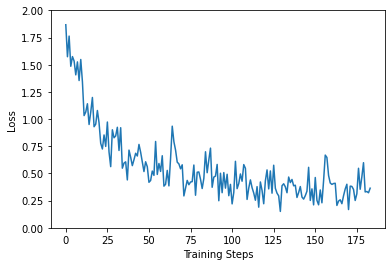

In [28]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

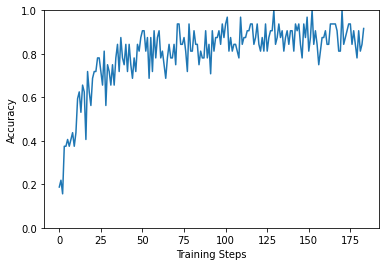

In [29]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

To redo the plot from before, first get the ordered list of class names:

In [30]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plot the result

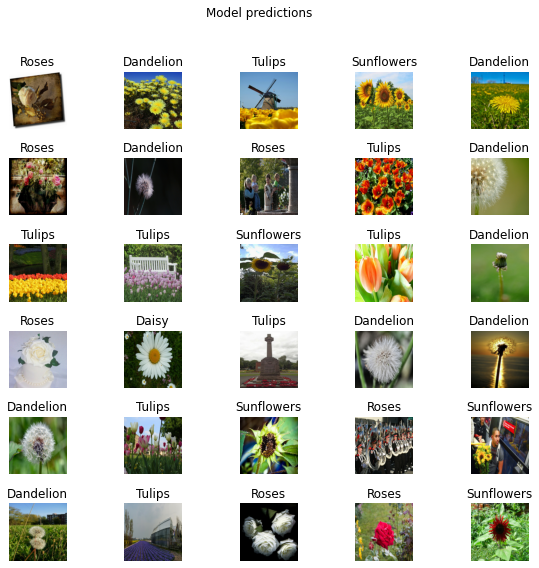

In [31]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Export your model

Now that you've trained the model, export it as a SavedModel for use later on.

In [32]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1621422617/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1621422617/assets


'/tmp/saved_models/1621422617'

Now confirm that we can reload it, and it still gives the same results:

In [33]:
reloaded = tf.keras.models.load_model(export_path)

In [34]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [35]:
abs(reloaded_result_batch - result_batch).max()

0.0

This SavedModel can be loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).


## Learn more

Check out more [tutorials](https://www.tensorflow.org/hub/tutorials) for using image models from TensorFlow Hub.